In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [6]:
new_cases_df = pd.read_csv('new_cases', index_col='Date')

In [7]:
new_cases_df

,NO2,CO,PM25,OZONE,PM10,NO,new_confirmed_cases
Date,,,,,,,
2020-01-26,0.020,0.4930,47.3,0.040,50.5,0.005,0.0
2020-01-27,0.042,0.8220,24.6,0.041,40.8,0.071,0.0
2020-01-28,0.042,0.7370,14.9,0.042,27.8,0.083,0.0
2020-01-29,0.031,0.7320,11.0,0.042,44.7,0.037,0.0
2020-01-30,0.043,1.0460,16.2,0.038,42.0,0.094,0.0
...,...,...,...,...,...,...,...
2020-10-14,0.040,1.0230,22.4,0.060,47.0,0.049,1223.0
2020-10-15,0.057,0.7690,22.9,0.059,48.8,0.054,1201.0
2020-10-16,0.041,0.7105,21.4,0.050,50.9,0.034,1041.0


In [ ]:
# Plot
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    print(len(new_cases_df.columns))
    if new_cases_df.columns[i]:
        data = new_cases_df[new_cases_df.columns[i]]
        ax.plot(data, color='red', linewidth=1)
        # Decorations
        ax.set_title(new_cases_df.columns[i])
        ax.xaxis.set_ticks_position('none')
        ax.yaxis.set_ticks_position('none')
        ax.spines["top"].set_alpha(0)
        ax.tick_params(labelsize=6)

plt.tight_layout()

In [11]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(new_cases_df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
NO2    ::  188.84    > 111.7797  =>   True
CO     ::  121.74    > 83.9383   =>   True
PM25   ::  81.03     > 60.0627   =>   True
OZONE  ::  43.51     > 40.1749   =>   True
PM10   ::  19.52     > 24.2761   =>   False
NO     ::  4.79      > 12.3212   =>   False
new_confirmed_cases ::  0.08      > 4.1296    =>   False


In [16]:
nobs = int(len(new_cases_df) * .15)
df_train, df_test = new_cases_df[0:-nobs], new_cases_df[-nobs:]

# Check size
print(df_train.shape)  # (119, 8)
print(df_test.shape)  # (4, 8)

(227, 7)
(40, 7)


In [17]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    

In [18]:
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "NO2" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.8678
 No. Lags Chosen       = 14
 Critical value 1%     = -3.462
 Critical value 5%     = -2.875
 Critical value 10%    = -2.574
 => P-Value = 0.0492. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "CO" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.8845
 No. Lags Chosen       = 12
 Critical value 1%     = -3.461
 Critical value 5%     = -2.875
 Critical value 10%    = -2.574
 => P-Value = 0.0022. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "PM25" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 

In [19]:
df_differenced = df_train.diff().dropna()

In [20]:
# ADF Test on each column of 1st Differences Dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "NO2" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.105
 No. Lags Chosen       = 13
 Critical value 1%     = -3.462
 Critical value 5%     = -2.875
 Critical value 10%    = -2.574
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "CO" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.8849
 No. Lags Chosen       = 11
 Critical value 1%     = -3.461
 Critical value 5%     = -2.875
 Critical value 10%    = -2.574
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "PM25" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 T

In [66]:
model = VAR(df_differenced)
for i in range(1,22):
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  -13.221065939716285
BIC :  -12.37083650627874
FPE :  1.8124047246358196e-06
HQIC:  -12.87790984979064 

Lag Order = 2
AIC :  -13.528521008228491
BIC :  -11.92931192142144
FPE :  1.3342837746589883e-06
HQIC:  -12.883002282398712 

Lag Order = 3
AIC :  -13.708676325716388
BIC :  -11.355741559775318
FPE :  1.1177764845426785e-06
HQIC:  -12.758812366527746 

Lag Order = 4
AIC :  -14.030173282000343
BIC :  -10.91871603641443
FPE :  8.153381846842552e-07
HQIC:  -12.773960558060734 

Lag Order = 5
AIC :  -14.379546249979674
BIC :  -10.504718192140427
FPE :  5.806907941671495e-07
HQIC:  -12.814959995551257 

Lag Order = 6
AIC :  -14.418861887199045
BIC :  -9.775762380598767
FPE :  5.668362212613733e-07
HQIC:  -12.543855796408936 

Lag Order = 7
AIC :  -14.400355563482211
BIC :  -8.984030881127072
FPE :  5.900763257744149e-07
HQIC:  -12.212861479038587 

Lag Order = 8
AIC :  -14.44837182159124
BIC :  -8.253814344284603
FPE :  5.79352259452757e-07
HQIC:  -11.946299417888518 

/opt/miniconda3/envs/tensorflow/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [83]:
model_fitted = model.fit(maxlags=15, ic='aic')
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 27, Oct, 2020
Time:                     13:03:32
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                   -9.77576
Nobs:                     220.000    HQIC:                  -12.5439
Log likelihood:          -298.091    FPE:                5.66836e-07
AIC:                     -14.4189    Det(Omega_mle):     1.62452e-07
--------------------------------------------------------------------
Results for equation NO2
                            coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------------
const                         -0.000171         0.000467           -0.367           0.714
L1.NO2                        -0.432461         0.171052           -2.528           0.011
L1.CO                     

In [84]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)
def adjust(val, length= 6): return str(val).ljust(length)
for col, val in zip(df.columns, out):
    print(adjust(col), ':', round(val, 2))

NO2    : 1.96
CO     : 2.04
PM25   : 2.01
OZONE  : 1.97
PM10   : 2.0
NO     : 2.05
new_confirmed_cases : 1.99


In [85]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
forecast_input

6


array([[-5.00e-03,  1.38e-01,  8.70e+00,  7.00e-03,  1.25e+01, -1.50e-02,
        -2.31e+02],
       [ 5.00e-03,  2.05e-01,  3.10e+00,  1.20e-02,  9.10e+00,  1.00e-03,
         2.71e+02],
       [ 2.00e-03,  1.70e-01,  1.90e+00,  1.20e-02, -1.30e+00,  0.00e+00,
        -1.92e+02],
       [-1.10e-02, -1.40e-01, -2.90e+00, -7.00e-03, -1.38e+01, -7.00e-03,
        -4.58e+02],
       [-6.00e-03, -2.29e-01,  4.91e+01, -2.40e-02,  2.20e+00, -6.00e-03,
        -2.29e+02],
       [-1.00e-03, -1.90e-01, -2.81e+01,  0.00e+00, -4.00e-01, -1.00e-03,
        -3.10e+01]])

In [86]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns=df.columns + '_1d')
df_forecast

,NO2_1d,CO_1d,PM25_1d,OZONE_1d,PM10_1d,NO_1d,new_confirmed_cases_1d
Date,,,,,,,
2020-09-09,0.004699,0.012226,-20.880212,0.003407,-1.707777,-0.004718,738.766130
2020-09-10,0.003454,0.050746,-6.725972,0.003984,-5.571554,0.014348,272.141471
2020-09-11,0.007643,0.168339,5.345851,0.004086,0.914170,0.014599,-303.354923
2020-09-12,0.001151,0.176226,18.092882,0.005135,8.889270,0.005701,-180.561589
2020-09-13,-0.003829,-0.029353,3.450620,-0.000008,12.060492,-0.014455,-43.613598
2020-09-14,-0.011986,-0.167636,-1.836645,-0.003691,-7.515781,-0.023011,-233.130078
2020-09-15,-0.001261,-0.097539,-2.618414,-0.003051,-5.606078,0.001699,222.521639
2020-09-16,0.004224,-0.002515,-3.889911,-0.000647,-2.668708,0.007190,4.347596
2020-09-17,0.005433,0.065683,-4.423645,-0.000068,-1.728720,0.010602,75.649228


In [87]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [88]:
df_results = invert_transformation(df_train, df_forecast, second_diff=False)        
# df_results.loc[:, ['rgnp_forecast', 'pgnp_forecast', 'ulc_forecast', 'gdfco_forecast',
#                    'gdf_forecast', 'gdfim_forecast', 'gdfcf_forecast', 'gdfce_forecast']]
df_results

,NO2_1d,CO_1d,PM25_1d,OZONE_1d,PM10_1d,NO_1d,new_confirmed_cases_1d,NO2_forecast,CO_forecast,PM25_forecast,OZONE_forecast,PM10_forecast,NO_forecast,new_confirmed_cases_forecast
Date,,,,,,,,,,,,,,
2020-09-09,0.004699,0.012226,-20.880212,0.003407,-1.707777,-0.004718,738.766130,0.017699,0.331226,25.019788,0.051407,37.592223,-0.002718,1190.766130
2020-09-10,0.003454,0.050746,-6.725972,0.003984,-5.571554,0.014348,272.141471,0.021153,0.381972,18.293816,0.055391,32.020669,0.011630,1462.907601
2020-09-11,0.007643,0.168339,5.345851,0.004086,0.914170,0.014599,-303.354923,0.028796,0.550312,23.639667,0.059477,32.934839,0.026229,1159.552678
2020-09-12,0.001151,0.176226,18.092882,0.005135,8.889270,0.005701,-180.561589,0.029947,0.726537,41.732549,0.064612,41.824108,0.031930,978.991089
2020-09-13,-0.003829,-0.029353,3.450620,-0.000008,12.060492,-0.014455,-43.613598,0.026118,0.697185,45.183169,0.064603,53.884600,0.017475,935.377491
2020-09-14,-0.011986,-0.167636,-1.836645,-0.003691,-7.515781,-0.023011,-233.130078,0.014132,0.529548,43.346524,0.060912,46.368819,-0.005536,702.247413
2020-09-15,-0.001261,-0.097539,-2.618414,-0.003051,-5.606078,0.001699,222.521639,0.012871,0.432009,40.728110,0.057861,40.762741,-0.003837,924.769052
2020-09-16,0.004224,-0.002515,-3.889911,-0.000647,-2.668708,0.007190,4.347596,0.017095,0.429493,36.838198,0.057214,38.094034,0.003353,929.116647
2020-09-17,0.005433,0.065683,-4.423645,-0.000068,-1.728720,0.010602,75.649228,0.022527,0.495176,32.414554,0.057146,36.365314,0.013955,1004.765875


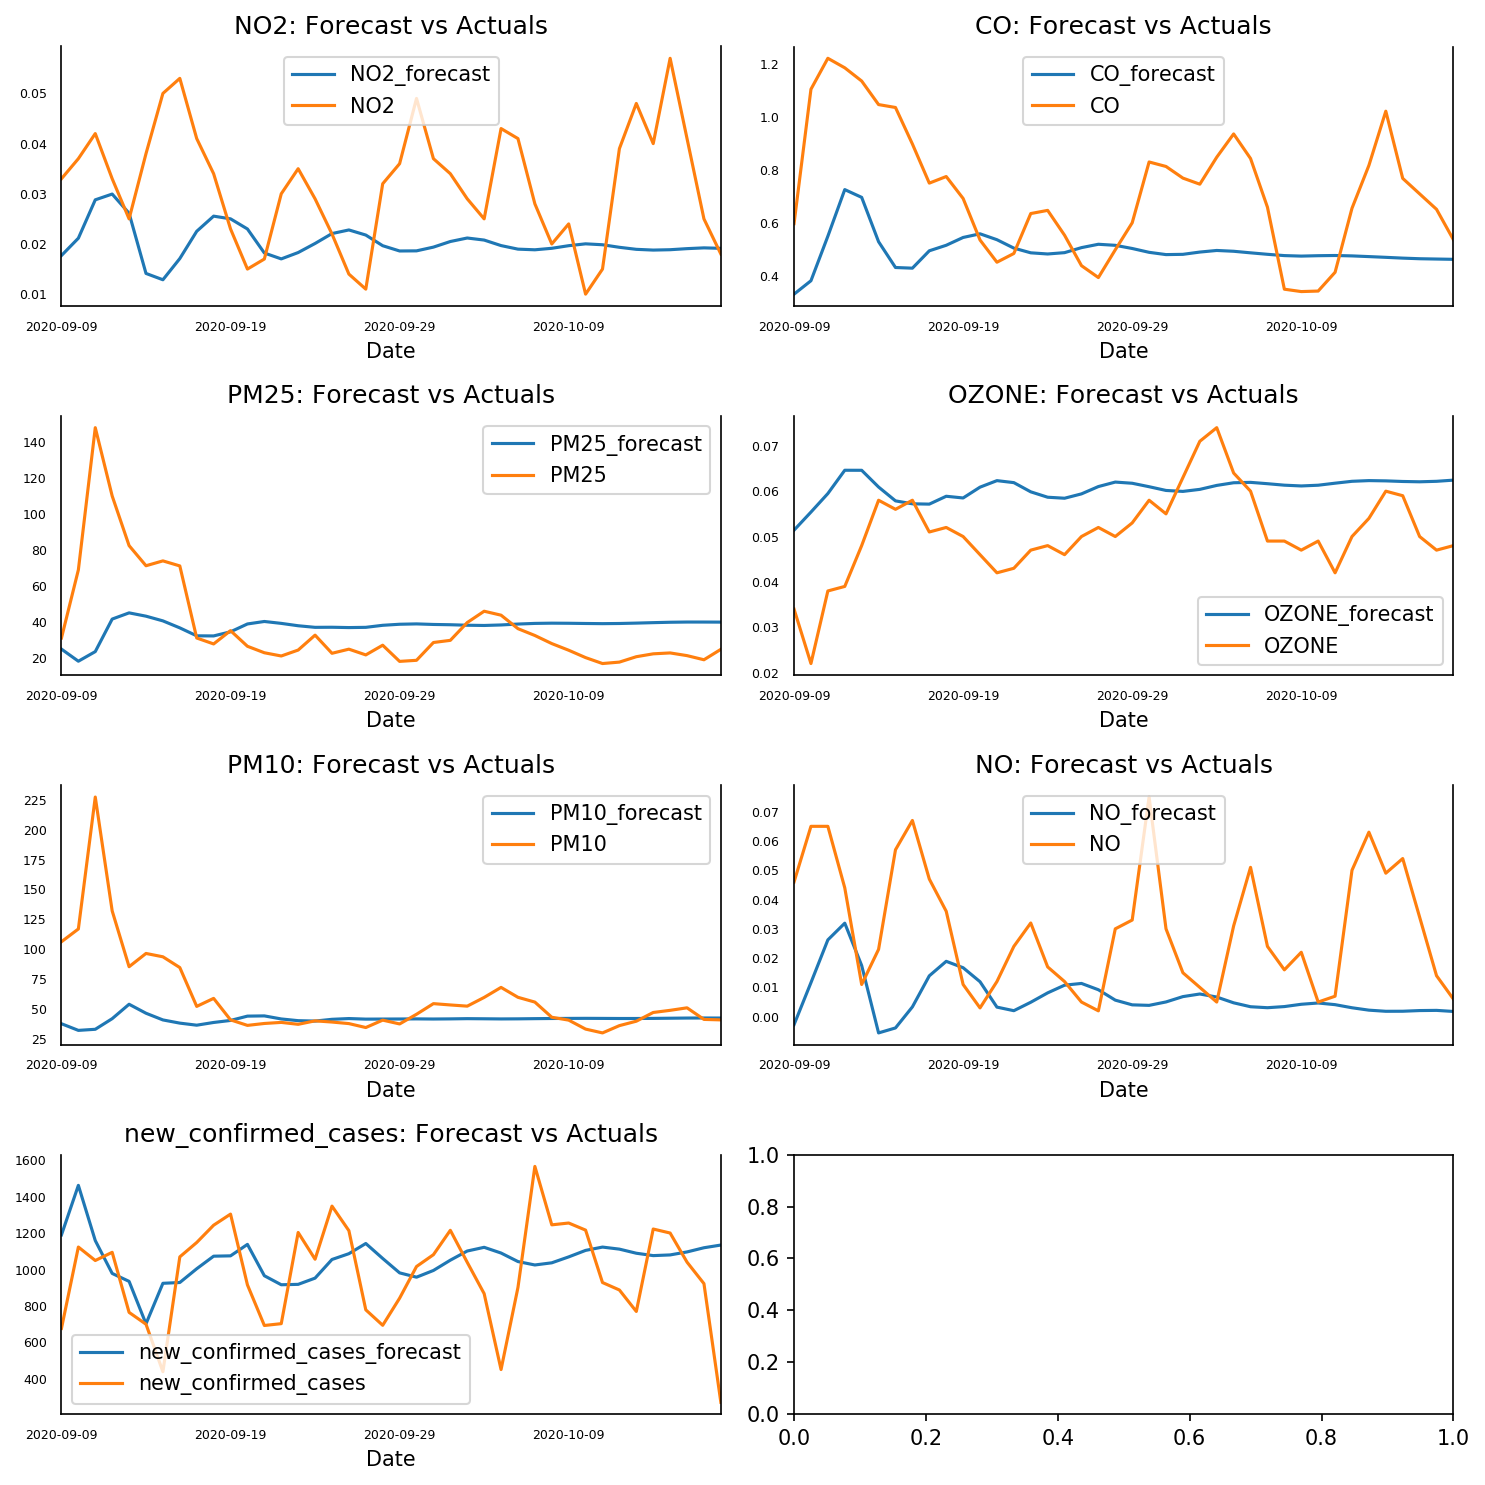

In [89]:
fig, axes = plt.subplots(nrows=int(len(new_cases_df.columns)/2) + 1, ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(new_cases_df.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [90]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

print('Forecast Accuracy of: NO2')
accuracy_prod = forecast_accuracy(df_results['NO2_forecast'].values, df_test['NO2'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: CO')
accuracy_prod = forecast_accuracy(df_results['CO_forecast'].values, df_test['CO'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: PM25')
accuracy_prod = forecast_accuracy(df_results['PM25_forecast'].values, df_test['PM25'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: OZONE')
accuracy_prod = forecast_accuracy(df_results['OZONE_forecast'].values, df_test['OZONE'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: PM10')
accuracy_prod = forecast_accuracy(df_results['PM10_forecast'].values, df_test['PM10'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: NO')
accuracy_prod = forecast_accuracy(df_results['NO_forecast'].values, df_test['NO'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: new_confirmed_cases')
accuracy_prod = forecast_accuracy(df_results['new_confirmed_cases_forecast'].values, df_test['new_confirmed_cases'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

Forecast Accuracy of: NO2
mape   :  0.4126
me     :  -0.0115
mae    :  0.0139
mpe    :  -0.2258
rmse   :  0.0173
corr   :  -0.2557
minmax :  0.3749

Forecast Accuracy of: CO
mape   :  0.3321
me     :  -0.2234
mae    :  0.2633
mpe    :  -0.228
rmse   :  0.3208
corr   :  0.2585
minmax :  0.3203

Forecast Accuracy of: PM25
mape   :  0.5577
me     :  -0.216
mae    :  19.725
mpe    :  0.3314
rmse   :  29.0766
corr   :  -0.2872
minmax :  0.3635

Forecast Accuracy of: OZONE
mape   :  0.2591
me     :  0.0097
mae    :  0.0112
mpe    :  0.2382
rmse   :  0.0132
corr   :  0.285
minmax :  0.184

Forecast Accuracy of: PM10
mape   :  0.2509
me     :  -17.9836
mae    :  21.5916
mpe    :  -0.1484
rmse   :  41.6848
corr   :  -0.3979
minmax :  0.2424

Forecast Accuracy of: NO
mape   :  0.872
me     :  -0.0233
mae    :  0.0251
mpe    :  -0.4067
rmse   :  0.0322
corr   :  -0.0141
minmax :  0.7158

Forecast Accuracy of: new_confirmed_cases
mape   :  0.336
me     :  73.0951
mae    :  234.7374
mpe    :  0.207